In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
from keras import backend as K
from sklearn.model_selection import train_test_split
import h5py

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

#K.tensorflow_backend.set_image_dim_ordering('th')
K.set_image_data_format('channels_last')

%matplotlib inline

np.random.seed(2)

2025-02-22 16:04:55.037481: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 16:04:55.317938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740251095.415223   10075 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740251095.443778   10075 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 16:04:55.692757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
target_size = (200, 200)
target_dims = (200, 200, 1)
num_classes = 5

# Função para verificar GPUs disponíveis
def get_available_gpus():
    gpus = tf.config.list_physical_devices('GPU')
    return gpus

def load_local_dataset(dataset_path, target_size=(200, 200)):
    classes = sorted(os.listdir(dataset_path))  # Obtém a lista de classes (pastas A, E, I, O, U)
    images, labels = [], []
    
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Carrega em escala de cinza
            if img is None:
                continue
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)  # Melhor interpolação para redução
            
            images.append(img)
            labels.append(label)
    
    images = np.array(images, dtype=np.uint8)  # Armazena como uint8 para economizar espaço
    labels = np.array(labels, dtype=np.uint8)  # Armazena labels como uint8 também
    
    return images, labels

def model():
    my_model = Sequential()
    my_model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=target_dims))
    my_model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
    my_model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
    my_model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dense(num_classes, activation='softmax'))

    my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

    return my_model

In [3]:
dataset_path = "dataset"
output_file = "vogais_dataset.h5"

# Carrega e processa o dataset
images, labels = load_local_dataset(dataset_path)

x_train, x_test, y_train, y_test = train_test_split(
        images, labels, 
        test_size=0.1, 
        stratify=labels,
        random_state=42)

x_train = x_train.reshape(-1, *target_dims)
x_test = x_test.reshape(-1, *target_dims)

x_train = x_train.astype('float16')
x_test = x_test.astype('float16')

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

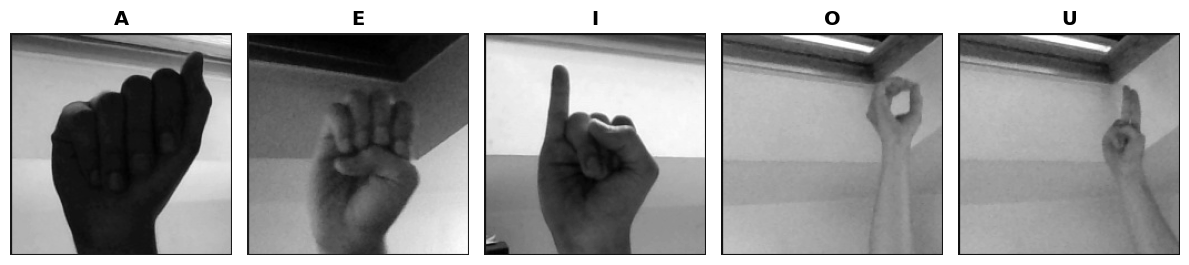

In [4]:
# Função para reverter one-hot encoding para labels inteiros
def reverse_one_hot(y):
    return np.argmax(y, axis=1)

# Reverte o one-hot encoding para y_train
y_train_int = reverse_one_hot(y_train)

# Mapeia os índices das vogais (supondo que classes = ['A', 'E', 'I', 'O', 'U'])
vogais = ['A', 'E', 'I', 'O', 'U']

# Seleciona uma imagem aleatória de cada classe
indices = [np.random.choice(np.where(y_train_int == i)[0]) for i in range(5)]

# Cria a figura
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[indices[i]].reshape(target_dims[:-1]), cmap='gray')
    ax.set_title(vogais[i], fontsize=14, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

filename = "libravogaisneuralnet.weights.h5"
gpus = get_available_gpus()
if gpus:
    print("GPUs disponíveis:", gpus[0].name)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
else:
    print("Nenhuma GPU disponível.")
model1 = model()

# Se retreinar = 1, o modelo será treinado novamente, 
# caso contrário, o modelo será carregado a partir de um arquivo .h5
retreinar = 0

epochs = 28
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
test_generator = datagen.flow(x_test, y_test, batch_size=batch_size)

# Verifica se já existe um modelo treinado e exportado para um arquivo .h5
if os.path.exists(filename) and retreinar == 0:
    model1.load_weights(filename)
    print("Modelo carregado de", filename)
else:
    model1.summary()
    history = model1.fit(train_generator, validation_data=test_generator, epochs=epochs)
    model1.save_weights(filename)


GPUs disponíveis: /physical_device:GPU:0
1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1740251110.376916   10075 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/diego/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modelo carregado de libravogaisneuralnet.weights.h5


/home/diego/.local/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
try:
    # Trace as curvas de perda e precisão para treinamento e validação
    plt.plot(history.history['val_loss'], color='b', label="validation loss")
    plt.title("Test Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
except:
    print("Modelo externo carregado. Não é possível plotar o gráfico de perda.")

Modelo externo carregado. Não é possível plotar o gráfico de perda.


In [7]:
scores = model1.evaluate(x_test, y_test, verbose=0)
print("\nacc: %.2f%%" % (scores[1]*100))

I0000 00:00:1740251112.715463   10241 service.cc:148] XLA service 0x7f0564007210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740251112.724428   10241 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-02-22 16:05:12.750872: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740251112.830251   10241 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1740251117.284104   10241 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



acc: 30.53%


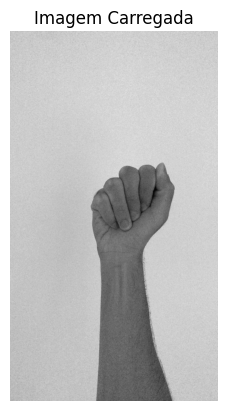

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Classe prevista: A com confiança de 99.04%


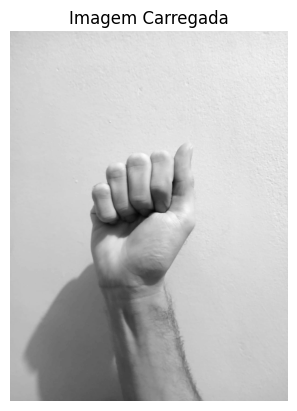

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Classe prevista: O com confiança de 85.06%


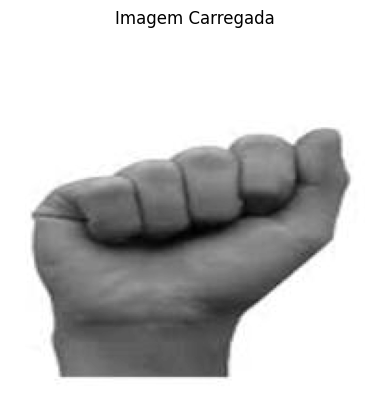

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Classe prevista: E com confiança de 80.15%


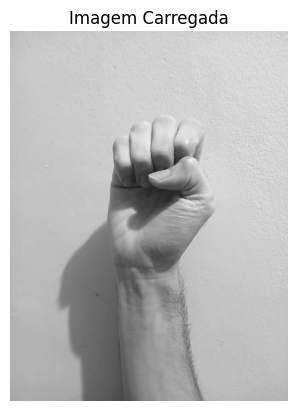

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Classe prevista: O com confiança de 99.37%


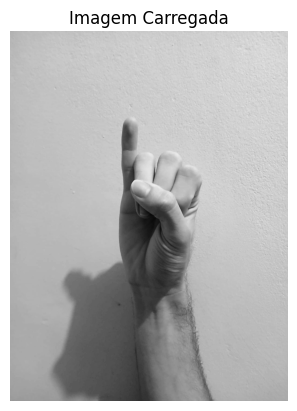

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Classe prevista: I com confiança de 83.46%


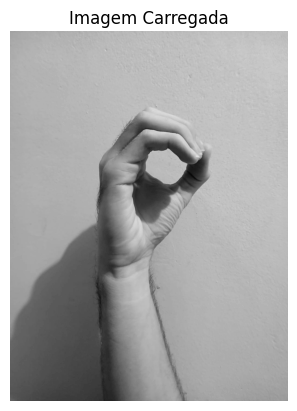

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Classe prevista: O com confiança de 96.16%


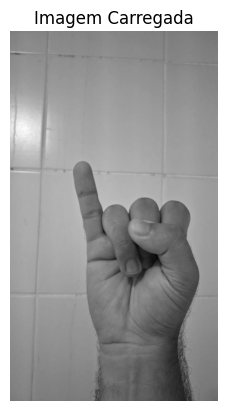

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Classe prevista: I com confiança de 99.84%


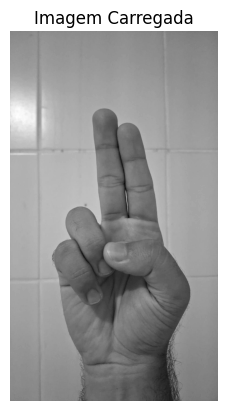

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Classe prevista: I com confiança de 98.80%


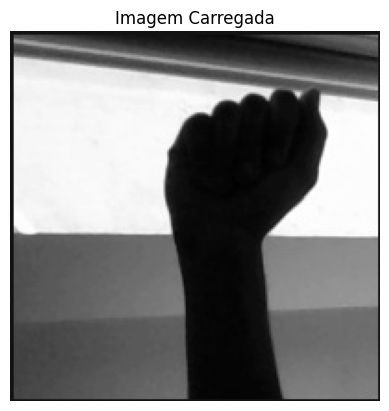

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Classe prevista: A com confiança de 100.00%


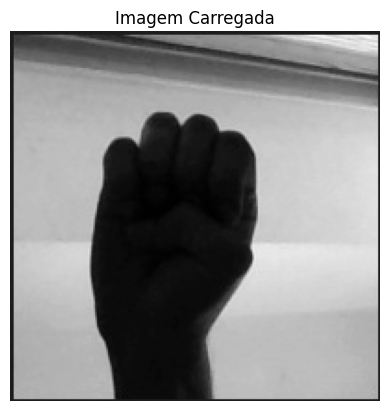

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Classe prevista: E com confiança de 100.00%


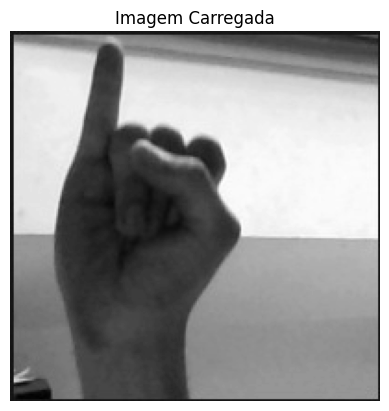

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Classe prevista: I com confiança de 100.00%


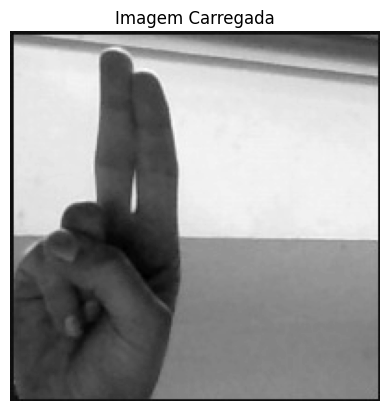

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Classe prevista: U com confiança de 100.00%


In [8]:

# Definiçao das classes
classes = ['A', 'E', 'I', 'O', 'U']

lista = ["A_diego.jpg", "A_gustavo.jpg", "A_internet.jpg", "E_gustavo.jpg", "I_gustavo.jpg", "O_gustavo.jpg", 
        "I_levy.jpg", "U_levy.jpg", "A_test.jpg", "E_test.jpg", "I_test.jpg", "U_test.jpg"]

for i in range(len(lista)):
    # Carregar a imagem
    img_path = "testes/" + lista[i]
    img_pred = cv2.imread(img_path, 0)  # Carregar em escala de cinza

    # Verificar se a imagem foi carregada corretamente
    if img_pred is None:
        raise FileNotFoundError("A imagem não pôde ser carregada. Verifique o caminho do arquivo.")

    # Exibir a imagem
    plt.imshow(img_pred, cmap='gray')
    plt.title("Imagem Carregada")
    plt.axis('off')  # Desativar eixos
    plt.show()

    # Redimensionar a imagem para 200x200
    img_pred = cv2.resize(img_pred, target_size)

    # Adicionar dimensão do canal (para 1 canal de escala de cinza)
    img_pred = np.expand_dims(img_pred, axis=-1)  # Formato (28, 28, 1)

    # Normalizar a imagem (valores entre 0 e 1)
    img_pred = img_pred.astype('float32') / 255.0

    # Adicionar dimensão do lote (1, 28, 28, 1)
    img_pred = np.expand_dims(img_pred, axis=0)

    # Fazer previsões
    predictions = model1.predict(img_pred)  # Obter as previsões
    pred = np.argmax(predictions, axis=1)  # Obter a classe prevista
    pred_proba = np.max(predictions, axis=1)  # Obter a probabilidade da classe prevista
    pred_proba = "%.2f%%" % (pred_proba[0] * 100)  # Formatar a probabilidade como porcentagem

    # Exibir resultados
    print("Classe prevista:", classes[pred[0]], "com confiança de", pred_proba)